In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Load data
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

df.isnull().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [24]:

# One-hot encode categorical feature
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)

# Fill missing values (e.g., with median)
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())


df.info()

# Split features and target
X = df.drop(["median_house_value", "total_bedrooms"], axis=1).astype(np.float32).values
y = df["median_house_value"].values / 100000.0  # Scale target




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   ocean_proximity_INLAND      20640 non-null  bool   
 10  ocean_proximity_ISLAND      20640 non-null  bool   
 11  ocean_proximity_NEAR BAY    20640 non-null  bool   
 12  ocean_proximity_NEAR OCEAN  20640 non-null  bool   
dtypes: bool(4), float64(9)
memory u

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a normalization layer and adapt to training data
normalizer = layers.Normalization()
normalizer.adapt(X_train)

# Build model with preprocessing inside
model = models.Sequential([
    normalizer,  # Preprocessing layer
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # Linear output for regression
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, verbose=1)

# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae * 100000:.2f} dollars")

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7574 - mae: 0.5807 - val_loss: 0.4285 - val_mae: 0.4687
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.3945 - mae: 0.4422 - val_loss: 0.4082 - val_mae: 0.4524
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.3521 - mae: 0.4159 - val_loss: 0.3672 - val_mae: 0.4167
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.3366 - mae: 0.4026 - val_loss: 0.3705 - val_mae: 0.4151
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.3299 - mae: 0.3968 - val_loss: 0.3637 - val_mae: 0.4213
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.3207 - mae: 0.3914 - val_loss: 0.3613 - val_mae: 0.4091
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.3124 - mae: 0.3856 - val_loss: 0.3485 - val_mae: 0.4087
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.3069 - mae: 0.3824 - val_loss: 0.3316 - val_mae: 0.3986
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
[1356 1649 3249 ... 2051  906 2904]


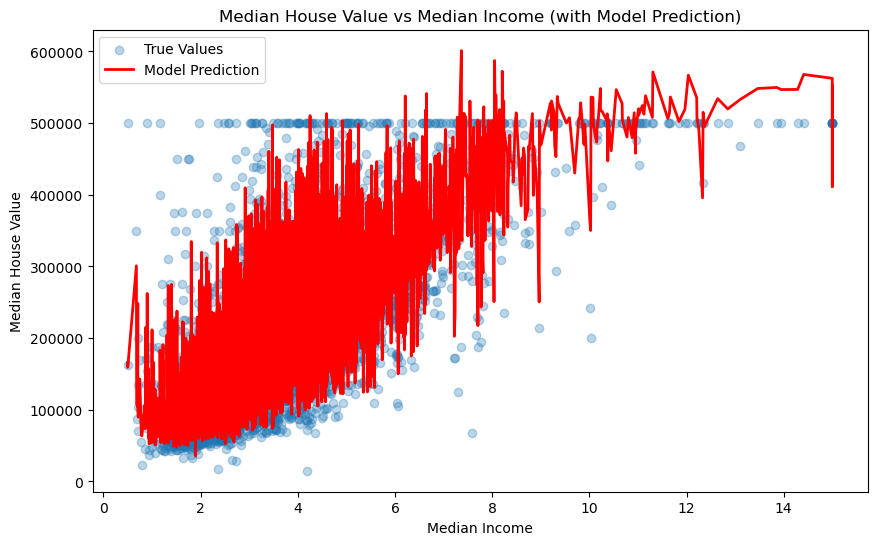

In [29]:
import matplotlib.pyplot as plt

# Get median_income column index (after dropping columns)
median_income_idx = df.drop(["median_house_value", "total_bedrooms"], axis=1).columns.get_loc("median_income")

# Get median_income for test set
median_income_test = X_test[:, median_income_idx]

# Predict house values for test set
y_pred = model.predict(X_test).flatten() * 100000  # Rescale

# True values (rescaled)
y_true = y_test * 100000

# Scatter plot: median_income vs true median_house_value
plt.figure(figsize=(10, 6))
plt.scatter(median_income_test, y_true, alpha=0.3, label="True Values")

# Sort for line plot
sorted_idx = np.argsort(median_income_test)
print(sorted_idx)
plt.plot(median_income_test[sorted_idx], y_pred[sorted_idx], color='red', label="Model Prediction", linewidth=2)

plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Median House Value vs Median Income (with Model Prediction)")
plt.legend()
plt.show()
